In [1]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import os
from statsmodels.tsa.api import VAR
from statsmodels.stats.stattools import durbin_watson
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np

In [2]:
curr_path = os.getcwd()
input_path = os.path.join(curr_path,'cleaned_data.xlsx')

data = pd.read_excel(
    input_path,
    engine='openpyxl',
)

data.dropna(inplace=True)
data.drop(['Date','IsExpanding'], axis=1, inplace=True)
n = 12
df_train, df_test = data[0:-n], data[-n:]

In [3]:
# Apply ADF test
for col in df_train.columns:
    print(col + ' ADF Test')
    result = adfuller(df_train[col].values)
    if result[1] < 0.05:
        print('stationary\n')
    else:
        print('not stationary\n')

SP500-EPS-Index ADF Test
not stationary

SP500-Price ADF Test
not stationary

UnemploymentRate ADF Test
stationary

IndustrialProduction ADF Test
not stationary

HousingSales ADF Test
not stationary

USDollarIndex ADF Test
not stationary

GS10 ADF Test
not stationary

VolumeOfTotalRetailTradeSales ADF Test
stationary



In [4]:
# apply difference method to df_train
df_train_trans = df_train.diff().dropna()

for col in df_train_trans.columns:
    print(col + ' ADF Test')
    result = adfuller(df_train_trans[col].values)
    if result[1] < 0.05:
        print('stationary\n')
    else:
        print('not stationary\n')

SP500-EPS-Index ADF Test
stationary

SP500-Price ADF Test
stationary

UnemploymentRate ADF Test
stationary

IndustrialProduction ADF Test
stationary

HousingSales ADF Test
stationary

USDollarIndex ADF Test
stationary

GS10 ADF Test
stationary

VolumeOfTotalRetailTradeSales ADF Test
stationary



In [5]:
# Use AIC to find Lag Order
model = VAR(df_train_trans)
for i in range(1, 16):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic, '\n')

Lag Order = 1
AIC :  22.920971740022683 

Lag Order = 2
AIC :  22.765612046278246 

Lag Order = 3
AIC :  22.38875141264802 



C:\Users\yuxin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


Lag Order = 4
AIC :  22.38504327712637 

Lag Order = 5
AIC :  22.38993647696972 

Lag Order = 6
AIC :  22.344649118733482 

Lag Order = 7
AIC :  22.441615379196218 

Lag Order = 8
AIC :  22.515774709370778 

Lag Order = 9
AIC :  22.49442929796127 

Lag Order = 10
AIC :  22.53272900971058 

Lag Order = 11
AIC :  22.515716009985162 

Lag Order = 12
AIC :  22.463422959964333 

Lag Order = 13
AIC :  22.454131119556262 

Lag Order = 14
AIC :  22.48327246733426 

Lag Order = 15
AIC :  22.526467795322734 



In [6]:
# Model Fitting and Granger Causality Test
results = model.fit(maxlags=6, ic='aic')

# Function borrowed from 
# https://stackoverflow.com/questions/58005681/is-it-possible-to-run-a-vector-autoregression-analysis-on-a-large-gdp-data-with
def grangers_causation_matrix(data, variables, maxlag, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df_train_trans, variables = df_train_trans.columns, maxlag = 6)

,SP500-EPS-Index_x,SP500-Price_x,UnemploymentRate_x,IndustrialProduction_x,HousingSales_x,USDollarIndex_x,GS10_x,VolumeOfTotalRetailTradeSales_x
SP500-EPS-Index_y,1.0000,0.0078,0.2558,0.0000,0.0542,0.0069,0.2174,0.0010
SP500-Price_y,0.0000,1.0000,0.0045,0.0000,0.0000,0.5604,0.2341,0.0005
UnemploymentRate_y,0.0000,0.0019,1.0000,0.0000,0.1151,0.0264,0.0037,0.0000
IndustrialProduction_y,0.0000,0.0000,0.0000,1.0000,0.0287,0.0735,0.0000,0.0000
HousingSales_y,0.0002,0.0001,0.0352,0.0051,1.0000,0.4086,0.2766,0.3933
USDollarIndex_y,0.2256,0.1265,0.0136,0.1855,0.0138,1.0000,0.1285,0.3082
GS10_y,0.0191,0.0120,0.0707,0.3062,0.2156,0.0085,1.0000,0.0022
VolumeOfTotalRetailTradeSales_y,0.3062,0.0124,0.0001,0.0000,0.1998,0.1508,0.0110,1.0000


In [7]:
# Drop predictors that failed the Test
df_train_trans = df_train_trans.drop(['UnemploymentRate','GS10'], axis=1)

model = VAR(df_train_trans)
for i in range(1, 16):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic, '\n')

C:\Users\yuxin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


Lag Order = 1
AIC :  29.176473446385888 

Lag Order = 2
AIC :  29.065933677655124 

Lag Order = 3
AIC :  28.68885383595255 

Lag Order = 4
AIC :  28.6368298756119 

Lag Order = 5
AIC :  28.641139327827403 

Lag Order = 6
AIC :  28.577899653232507 

Lag Order = 7
AIC :  28.625296434128867 

Lag Order = 8
AIC :  28.65373488038812 

Lag Order = 9
AIC :  28.655376160159577 

Lag Order = 10
AIC :  28.633016229703802 

Lag Order = 11
AIC :  28.594185866215547 

Lag Order = 12
AIC :  28.52919119668513 

Lag Order = 13
AIC :  28.480876980634083 

Lag Order = 14
AIC :  28.52910288718971 

Lag Order = 15
AIC :  28.565021952840393 



In [8]:
# maxlags changed to 13
results = model.fit(maxlags=13, ic='aic')

# detect autocorrelation in residuals
dw_output = durbin_watson(results.resid)
for col, val in zip(df_train_trans.columns, dw_output):
    print(col, ':', round(val, 2))

SP500-EPS-Index : 1.95
SP500-Price : 2.0
IndustrialProduction : 2.0
HousingSales : 2.0
USDollarIndex : 2.0
VolumeOfTotalRetailTradeSales : 2.0


In [9]:
# Granger Causality Check
grangers_causation_matrix(df_train_trans, variables = df_train_trans.columns, maxlag = 13)

,SP500-EPS-Index_x,SP500-Price_x,IndustrialProduction_x,HousingSales_x,USDollarIndex_x,VolumeOfTotalRetailTradeSales_x
SP500-EPS-Index_y,1.0000,0.0000,0.0000,0.0008,0.0024,0.0000
SP500-Price_y,0.0000,1.0000,0.0000,0.0000,0.3364,0.0005
IndustrialProduction_y,0.0000,0.0000,1.0000,0.0287,0.0735,0.0000
HousingSales_y,0.0000,0.0001,0.0051,1.0000,0.4086,0.3933
USDollarIndex_y,0.1871,0.0983,0.1855,0.0138,1.0000,0.3082
VolumeOfTotalRetailTradeSales_y,0.0239,0.0124,0.0000,0.1270,0.1508,1.0000


In [10]:
# Prediction
df_test_trans = data.diff().dropna()[-n:]

lag = results.k_ar
data_pred = results.forecast(y=df_train_trans.values[-lag:], steps=n)
df_forecast = (pd.DataFrame(data_pred, index=df_test.index, columns=df_train_trans.columns + '_pred'))
df_result = pd.concat([df_forecast['SP500-EPS-Index_pred'], df_test_trans['SP500-EPS-Index'].dropna()], axis=1)

rmse = mean_squared_error(df_result['SP500-EPS-Index_pred'], df_result['SP500-EPS-Index'], squared=False)
print('RMSE: ', round(rmse,2))

RMSE:  24.47


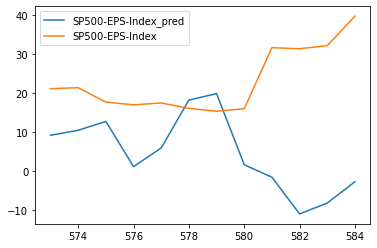

In [11]:
df_result.plot()

In [12]:
# Detransformation
df_result['SP500-EPS-Index_pred'] = df_train['SP500-EPS-Index'].iloc[-1] + df_result['SP500-EPS-Index_pred'].cumsum()
df_result['SP500-EPS-Index'] = df_train['SP500-EPS-Index'].iloc[-1] + df_result['SP500-EPS-Index'].cumsum()

rmse2 = mean_squared_error(df_result['SP500-EPS-Index_pred'], df_result['SP500-EPS-Index'], squared=False)
print('RMSE: ', round(rmse2,2))

RMSE:  101.75


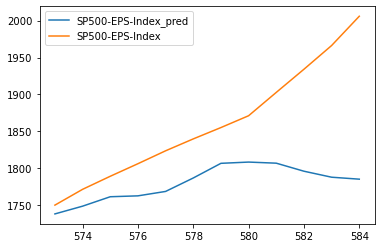

In [13]:
df_result.plot()